<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Obter os dataframes dos ficheiros

In [2]:
metrics_dict={}
tentativa = 0

In [3]:
failures_df, signals_df, logs_df = dprep.get_data()

In [4]:
df_list = [failures_df, signals_df, logs_df]

# Criação de datasets de components

In [5]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [6]:
comp_df_list = [df_generator, df_hydraulic, df_gen_bear, df_transformer,  df_gearbox]

In [7]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(434145, 45)
(434145, 31)
(434145, 45)
(434145, 36)
(434145, 33)


In [8]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Cópia dos df para só carregar uma vez no ficheiro

In [333]:
comp_prep_df_list = comp_df_list.copy()

# Merge dos DF com o DF de failures

In [334]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.sig_fail_merge_dfs(sig_df=comp_prep_df_list[i],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [335]:
for i in comp_df_list:
    print(i.shape)

(434145, 45)
(434145, 31)
(434145, 45)
(434145, 36)
(434145, 33)


# Fillna by turbine

In [336]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [337]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.fill_na_by_turbine(comp_prep_df_list[i], turbine_list)

C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  index['date'] = index['Timestamp']
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:178: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_ = pd.concat([df_, df_final])
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [338]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 47)
(434145, 33)
(434145, 47)
(434145, 38)
(434145, 35)


# Criação de Variável alvo

In [339]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].isna().sum().value_counts())

0    47
dtype: int64
0    33
dtype: int64
0    47
dtype: int64
0    38
dtype: int64
0    35
dtype: int64


In [340]:
days_list = [40]

In [341]:
for day in days_list:
    for i in range(len(comp_prep_df_list)):
        comp_prep_df_list[i] = dprep.aplic_var_target(comp_prep_df_list[i], day)

In [342]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 48)
(434145, 34)
(434145, 48)
(434145, 39)
(434145, 36)


# Feature selection

In [343]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(48,)
(34,)
(48,)
(39,)
(36,)


In [344]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [345]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [346]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [347]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [348]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [349]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [350]:
for df in range(len(comp_prep_df_list)):
    print(f'A actualizar dataframe {df+1} de {len(comp_prep_df_list)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_prep_df_list[df] = comp_prep_df_list[df].drop(columns=feat_drop_list[df])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [351]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 31)
(434145, 23)
(434145, 31)
(434145, 28)
(434145, 26)


In [352]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(31,)
(23,)
(31,)
(28,)
(26,)


# Agrupar pela medida de tempo seleccionada.

In [353]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(434147, 31)
(434145, 23)
(434145, 31)
(434145, 28)
(434145, 26)


In [354]:
# Passagem para dias
Agrup_por = 'Hora'
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.group_por_frequency(comp_prep_df_list[i], period=Agrup_por)

In [355]:
# Passagem para dias 
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(72445, 31)
(72444, 16)
(72444, 18)
(72444, 19)
(72444, 16)


# Adicionar as medidas de alisamento

In [356]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(72445, 31)
(72444, 16)
(72444, 18)
(72444, 19)
(72444, 16)


In [357]:
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.add_features(comp_prep_df_list[i])

In [358]:
cols_to_drop = [
    'Date', 'Amb_Temp_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
    'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
    'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
    'Component', 'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
    'Cont_VCP_WtrTemp_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
    'Gen_Phase2_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
    'Gen_SlipRing_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Grd_RtrInvPhase2_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Nac_Direction_Avg',
    'Nac_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
    'Prod_LatestAvg_ReactPwrGen0'
]
comp_prep_df_list[0].drop(columns=cols_to_drop)

,Turbine_ID,TTF,40_days,Amb_Temp_Avg_av,Amb_WindDir_Abs_Avg_av,Amb_WindDir_Relative_Avg_av,Amb_WindSpeed_Avg_av,Amb_WindSpeed_Max_av,Amb_WindSpeed_Min_av,Amb_WindSpeed_Std_av,...,Gen_RPM_Std_sd,Gen_SlipRing_Temp_Avg_sd,Grd_Busbar_Temp_Avg_sd,Grd_RtrInvPhase2_Temp_Avg_sd,Hyd_Oil_Temp_Avg_sd,Nac_Direction_Avg_sd,Nac_Temp_Avg_sd,Prod_LatestAvg_ActPwrGen0_sd,Prod_LatestAvg_ActPwrGen1_sd,Prod_LatestAvg_ReactPwrGen0_sd
0,T01,0.0,0.0,18.000000,220.366667,1.000000,4.216667,10.266667,0.983333,0.983333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,T01,0.0,0.0,18.000000,221.416667,0.758333,4.508333,11.866667,1.100000,0.991667,...,105.170349,0.589256,0.471405,0.353553,0.000000,1.803122,0.117851,175.951737,4406.218056,148.138871
2,T01,0.0,0.0,18.000000,222.100000,1.700000,4.061111,10.338889,0.916667,0.888889,...,74.643942,0.673575,0.384900,1.040833,0.000000,1.348078,0.254588,530.700699,11017.170651,530.304271
3,T01,0.0,0.0,18.000000,219.341667,2.120833,3.666667,9.150000,0.808333,0.816667,...,69.126745,1.264728,2.051986,2.878319,0.083333,6.463851,0.645497,715.960072,11825.346614,695.912955
4,T01,0.0,0.0,18.000000,216.753333,4.740000,3.360000,8.223333,0.743333,0.756667,...,65.542375,1.805085,3.233935,3.648820,0.434613,12.926714,1.023339,661.966983,11462.686086,605.117764
5,T01,0.0,0.0,18.000000,214.300000,9.325000,3.058333,7.636111,0.691667,0.705556,...,61.277039,2.129163,3.879672,3.984693,0.702509,20.757212,1.148671,592.360752,10920.410587,570.659284
6,T01,0.0,0.0,18.000000,214.900000,9.385714,3.138095,7.735714,0.733333,0.704762,...,56.814214,1.993043,4.096069,3.639692,0.822147,19.002852,1.104344,579.651186,10127.809432,564.827052
7,T01,0.0,0.0,18.000000,216.466667,8.320833,3.395833,8.002083,0.875000,0.710417,...,54.115591,1.868574,3.799540,3.797451,0.839265,19.105223,1.076443,602.897497,12044.234811,561.467196
8,T01,0.0,0.0,18.000000,214.901852,5.885185,3.383333,8.446296,0.853704,0.731481,...,71.571249,1.749559,3.559460,3.552625,0.805556,18.059540,1.008452,567.363616,11287.588376,530.511906
9,T01,0.0,0.0,18.000000,214.568333,6.088333,3.451667,8.426667,0.858333,0.740000,...,81.634693,1.650757,3.362878,3.479614,0.761739,17.112055,0.951931,536.286097,10662.918688,500.188171


In [359]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(72445, 85)
(72444, 40)
(72444, 46)
(72444, 49)
(72444, 40)


# Train and test split

In [360]:
# Separar os dataframes de treino e teste
df_train = [0, 0, 0, 0, 0]
df_test = [0, 0, 0, 0, 0]

per_test = '3meses'

for i in range(len(comp_prep_df_list)):
    df_train[i] = dprep.prepare_train_df(comp_prep_df_list[i].copy())
    df_test[i] = dprep.prepare_test_df(comp_prep_df_list[i].copy())

In [361]:
for i in range(len(df_train)):
    print(f'df_train {i} com a forma {df_train[i].shape}')
    print(f'df_test {i} com a forma {df_test[i].shape}')

df_train 0 com a forma (61535, 85)
df_test 0 com a forma (10910, 85)
df_train 1 com a forma (61534, 40)
df_test 1 com a forma (10910, 40)
df_train 2 com a forma (61534, 46)
df_test 2 com a forma (10910, 46)
df_train 3 com a forma (61534, 49)
df_test 3 com a forma (10910, 49)
df_train 4 com a forma (61534, 40)
df_test 4 com a forma (10910, 40)


# Criar o x_train, x_test, y_train e o y_test 

In [362]:
x_train = [0, 0, 0, 0, 0]
x_test = [0, 0, 0, 0, 0]
y_train = [0, 0, 0, 0, 0]
y_test = [0, 0, 0, 0, 0]

dias_var_alvo = days_list[0]

for i in range(len(df_train)):
    x_train[i] = df_train[i].copy()
    x_test[i] = df_test[i].copy()
    y_train[i] = df_train[i].copy()
    y_test[i] = df_test[i].copy()

In [363]:
# retirar as colunas que não devem entrar no x
cols_to_drop_train = ['Date', 'TTF', str(days_list[0])+'_days', 'Component']
for i in range(len(x_train)):
    x_train[i].drop(columns=cols_to_drop_train, inplace=True)
    x_test[i].drop(columns=cols_to_drop_train, inplace=True)

In [364]:
for i in range(len(x_train)):
    print(f'x_train {i} com a forma {x_train[i].shape}')
    print(f'x_test {i} com a forma {x_test[i].shape}')

x_train 0 com a forma (61535, 81)
x_test 0 com a forma (10910, 81)
x_train 1 com a forma (61534, 36)
x_test 1 com a forma (10910, 36)
x_train 2 com a forma (61534, 42)
x_test 2 com a forma (10910, 42)
x_train 3 com a forma (61534, 45)
x_test 3 com a forma (10910, 45)
x_train 4 com a forma (61534, 36)
x_test 4 com a forma (10910, 36)


In [365]:
# considerar apenas as colunas que devem ser a variável alvo
col_to_mantain_test = [str(days_list[0])+'_days']
for i in range(len(x_test)):
    y_train[i] = y_train[i][col_to_mantain_test]
    y_test[i] = y_test[i][col_to_mantain_test]

In [366]:
for i in range(len(y_test)):
    print(f'y_train {i} com a forma {y_train[i].shape}')
    print(f'y_test {i} com a forma {y_test[i].shape}')

y_train 0 com a forma (61535, 1)
y_test 0 com a forma (10910, 1)
y_train 1 com a forma (61534, 1)
y_test 1 com a forma (10910, 1)
y_train 2 com a forma (61534, 1)
y_test 2 com a forma (10910, 1)
y_train 3 com a forma (61534, 1)
y_test 3 com a forma (10910, 1)
y_train 4 com a forma (61534, 1)
y_test 4 com a forma (10910, 1)


# Primeira tentativa

In [367]:
X_train, X_test = dprep.scale(x_train[0], x_test[0])

In [368]:
y_train = y_train[0].to_numpy().astype(int)[:,0]
y_test = y_test[0].to_numpy().astype(int)[:,0]

In [369]:
#def bin_classify(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
model = 'Logistic Regression'
clf_LogReg = LogisticRegression(random_state=42, max_iter=1000)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_LogReg, pred_LogReg = dprep.bin_classify(model,
                                             clf_LogReg,
                                             X_train,
                                             X_test,
                                             y_train,
                                             y_test,
                                             params=gs_params,
                                             score=gs_score)
print('\nBest Parameters:\n', clf_LogReg)


Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


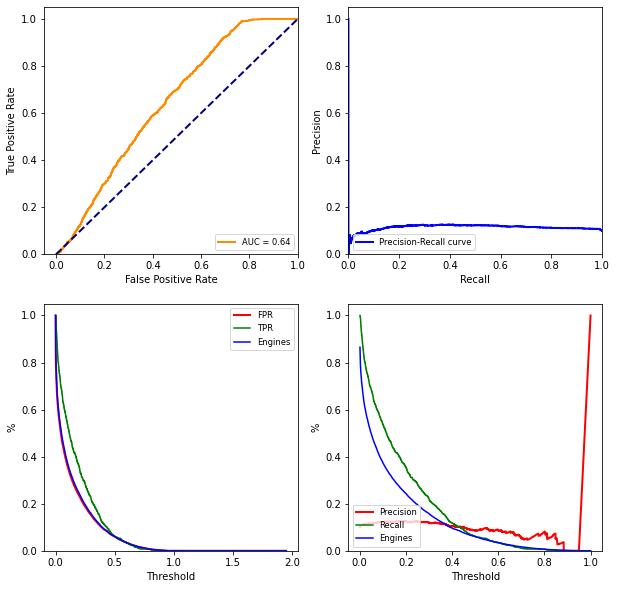

In [370]:
metrics_LogReg, roc_LogReg, prc_LogReg, cf_matriX_log_reg = dprep.bin_class_metrics(
    model,
    y_test,
    pred_LogReg.y_pred,
    pred_LogReg.y_score,
    print_out=True,
    plot_out=True)

In [371]:
tentativa = tentativa + 1

In [372]:
metrics_dict['try_'+str(tentativa)] =  {
        'Component': component_list[0],
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'metrics_LogReg': metrics_LogReg,
        'roc_LogReg': roc_LogReg,
        'prcn_LogReg': prc_LogReg,
        'cf_matriX_log_reg': cf_matriX_log_reg
    }

In [373]:
metrics_dict['try_'+str(tentativa)]#, metrics_dict['try002']['cf_matriX_log_reg']

{'Component': 'GENERATOR',
 'dias_var_alvo': ['40_days'],
 'feature_selection': 'Guilherme',
 'Agrup_por': 'Hora',
 'add_features': 'smooth only',
 'per_test': '3meses',
 'metrics_LogReg':            Logistic Regression
 Accuracy              0.864345
 Precision             0.086495
 Recall                0.060963
 F1 Score              0.071518
 ROC AUC               0.640843,
 'roc_LogReg':          Threshold       TPR       FPR       Que  TP  FP  TN  FN       TNR  \
 0     1.949570e+00  0.000000  0.000000  0.000000   0  25  75   0  1.000000   
 1     9.495697e-01  0.000000  0.000100  0.000092   0  25  74   0  1.000000   
 2     8.842295e-01  0.000000  0.002607  0.002383   0  25  74   0  1.000000   
 3     8.831869e-01  0.001070  0.002607  0.002475   0  24  74   0  1.000000   
 4     8.567043e-01  0.001070  0.003609  0.003391   0  24  74   0  1.000000   
 5     8.537158e-01  0.002139  0.003609  0.003483   0  24  74   0  1.000000   
 6     8.483397e-01  0.002139  0.003810  0.003666   

In [374]:
for i in metrics_dict.keys():
    print(metrics_dict[i]['dias_var_alvo'])
    print(metrics_dict[i]['Agrup_por'])
    print(metrics_dict[i]['metrics_LogReg'])
    print(metrics_dict[i]['cf_matriX_log_reg'])

['60_days']
Dia
           Logistic Regression
Accuracy              0.866667
Precision             0.000000
Recall                0.000000
F1 Score              0.000000
ROC AUC               0.576506
[[403   4]
 [ 58   0]]
['60_days']
Hora
           Logistic Regression
Accuracy              0.862420
Precision             0.083333
Recall                0.007908
F1 Score              0.014445
ROC AUC               0.565580
[[9398  121]
 [1380   11]]
['50_days']
Hora
           Logistic Regression
Accuracy              0.884143
Precision             0.082707
Recall                0.009540
F1 Score              0.017107
ROC AUC               0.570681
[[9635  122]
 [1142   11]]
['45_days']
Hora
           Logistic Regression
Accuracy              0.891751
Precision             0.074324
Recall                0.010427
F1 Score              0.018288
ROC AUC               0.607703
[[9718  137]
 [1044   11]]
['40_days']
Hora
           Logistic Regression
Accuracy              0.900367
Precis

In [399]:
import csv
import json

In [376]:
w = csv.writer(open("output.csv", "w"))
for key, val in metrics_dict.items():
    w.writerow([key, val])

In [403]:
metrics_dict['try_8']

{'Component': 'GENERATOR',
 'dias_var_alvo': ['40_days'],
 'feature_selection': 'Guilherme',
 'Agrup_por': 'Hora',
 'add_features': 'smooth only',
 'per_test': '3meses',
 'metrics_LogReg':            Logistic Regression
 Accuracy              0.864345
 Precision             0.086495
 Recall                0.060963
 F1 Score              0.071518
 ROC AUC               0.640843,
 'roc_LogReg':          Threshold       TPR       FPR       Que  TP  FP  TN  FN       TNR  \
 0     1.949570e+00  0.000000  0.000000  0.000000   0  25  75   0  1.000000   
 1     9.495697e-01  0.000000  0.000100  0.000092   0  25  74   0  1.000000   
 2     8.842295e-01  0.000000  0.002607  0.002383   0  25  74   0  1.000000   
 3     8.831869e-01  0.001070  0.002607  0.002475   0  24  74   0  1.000000   
 4     8.567043e-01  0.001070  0.003609  0.003391   0  24  74   0  1.000000   
 5     8.537158e-01  0.002139  0.003609  0.003483   0  24  74   0  1.000000   
 6     8.483397e-01  0.002139  0.003810  0.003666   